In [1]:
"""
Author: Michele Guida
Date: 2025-06-16
Description: Classify the method for discovery exoplanets using the Exoplanets — Method Classification Dataset.
"""

'\nAuthor: Michele Guida\nDate: 2025-06-16\nDescription: Classify the method for discovery exoplanets using the Exoplanets — Method Classification Dataset.\n'

In [2]:
# Main libraries required to run the notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import missingno as msno


# Load the dataset

In [3]:
url = "./exoplanet.csv"
df = pd.read_csv(url)

# Discovered exoplanets and main characteristics

**Number of instances:** 1035 planets

**Task:** Classification → Predict `method` (discovery method)

---

## Dataset columns

- **method**: Discovery method (e.g., "Radial Velocity", "Transit", etc.)
- **number**: Number of planets in the discovered system
- **orbital_period**: Orbital period of the planet (in days)
- **mass**: Planet mass in Jupiter masses (contains missing values)
- **distance**: Distance from Earth (in light years)
- **year**: Year of discovery


In [4]:
df

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


### From Multiclass to Binary Classification
I chose to focus exclusively on the "Radial Velocity" and "Transit" methods, as they represent the vast majority of cases in the dataset.
This selection allows me to turn the problem into a binary classification, simplifying the analysis and reducing the difficulties related to the presence of underrepresented classes.

An alternative could be to group all less frequent methods into an "Other" class.
However, this solution would introduce a very heterogeneous and uninformative class, making it harder for the model to identify clear patterns.
Moreover, the strong numerical disparity between classes could compromise the model's performance and evaluation.

By limiting myself to the two main classes, I obtain a simpler, more robust model with more easily interpretable results.



In [5]:
df = df.query("method == 'Radial Velocity' or method == 'Transit'")
df

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300000,7.10,77.40,2006
1,Radial Velocity,1,874.774000,2.21,56.95,2008
2,Radial Velocity,1,763.000000,2.60,19.84,2011
3,Radial Velocity,1,326.030000,19.40,110.62,2007
4,Radial Velocity,1,516.220000,10.50,119.47,2009
...,...,...,...,...,...,...
1030,Transit,1,3.941507,NaN,172.00,2006
1031,Transit,1,2.615864,NaN,148.00,2007
1032,Transit,1,3.191524,NaN,174.00,2007
1033,Transit,1,4.125083,NaN,293.00,2008


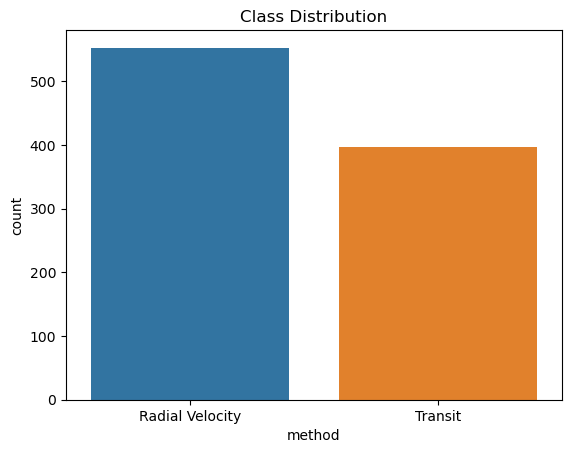

In [6]:
sns.countplot(df,x="method",hue="method")
plt.title("Class Distribution")
plt.show()

## Missing Values

There are missing values in only two columns:  
- `mass`: about **46%** of the values are missing  
- `distance`: about **20%** of the values are missing  

These percentages are quite significant, so careful handling is necessary to avoid introducing bias and losing information.

In [7]:
missing_values = pd.DataFrame()
missing_values["number"] = df.isna().sum()
missing_values["ratio"] = df.isna().mean() * 100
missing_values

,number,ratio
method,0,0.000000
number,0,0.000000
orbital_period,0,0.000000
mass,439,46.210526
distance,196,20.631579
year,0,0.000000


I observe that missing values in the `mass` and `distance` columns are predominantly associated with the **"Transit"** discovery method.
This suggests that the missingness is not completely random, but depends on the `method` variable, i.e., the technique by which each exoplanet was discovered.
Technically, these are **MAR (Missing At Random)** values, where the probability that a value is missing depends on other observed variables but not on the missing value itself.


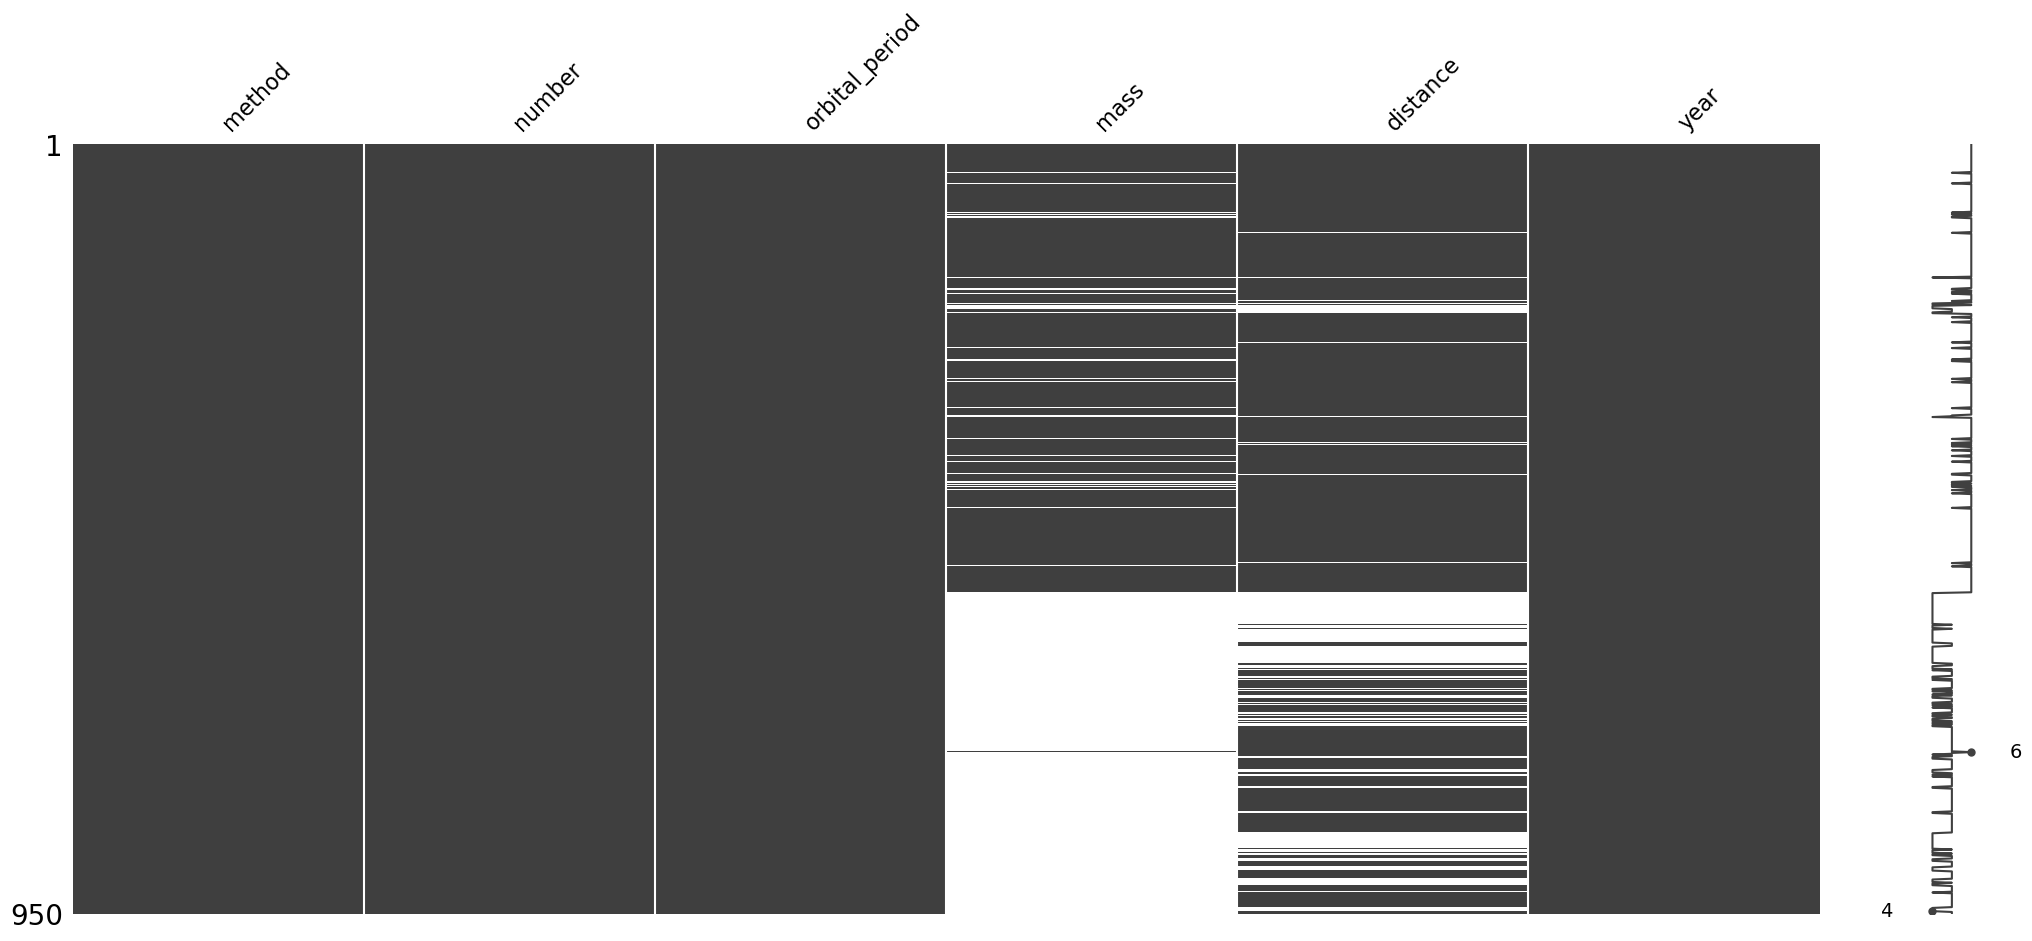

In [8]:
df_sorted = df.sort_values(by='method')
msno.matrix(df_sorted)
plt.show()

In [9]:
print("Transit:")
print(df.query("method == 'Transit'").isna().mean() * 100)
print("\nRadial Velocity:")
print(df.query("method == 'Radial Velocity'").isna().mean() * 100)

Transit:
method             0.000000
number             0.000000
orbital_period     0.000000
mass              99.748111
distance          43.576826
year               0.000000
dtype: float64

Radial Velocity:
method            0.000000
number            0.000000
orbital_period    0.000000
mass              7.775769
distance          4.159132
year              0.000000
dtype: float64


Therefore, to handle the missing values, I decided to create two new boolean columns:
- `has_mass`: indicates whether the `mass` value is missing
- `has_distance`: indicates whether the `distance` value is missing

In this way, I can retain the original information without losing existing data or introducing significant bias.  
Furthermore, by removing the original `mass` and `distance` columns, I avoid introducing noise into the machine learning models, which might otherwise try to "guess" the missing values based on other features.

In [ ]:
df["has_mass"] = df["mass"].isna()
df = df.drop(columns="mass")
df["has_distance"] = df["distance"].isna()
df = df.drop(columns="distance")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          950 non-null    object 
 1   number          950 non-null    int64  
 2   orbital_period  950 non-null    float64
 3   year            950 non-null    int64  
 4   has_mass        950 non-null    bool   
 5   has_distance    950 non-null    bool   
dtypes: bool(2), float64(1), int64(2), object(1)
memory usage: 39.0+ KB


## Univariate Analysis of Numerical Features

I now proceed with the univariate analysis of the main remaining numerical features (`number`, `orbital_period`, `year`) to assess their distribution, the presence of any outliers, and their relationship with the target variable `method`.  
For this analysis, I use histograms and boxplots, which are useful tools for visualizing both the shape of the distributions and the differences between classes for each variable.

From the following plots we can observe that:
- The `number` column shows a power-law distribution. Furthermore, it is evident that the `number` feature does not have strong discriminative power between the two discovery methods, as the distributions split by method are very similar.

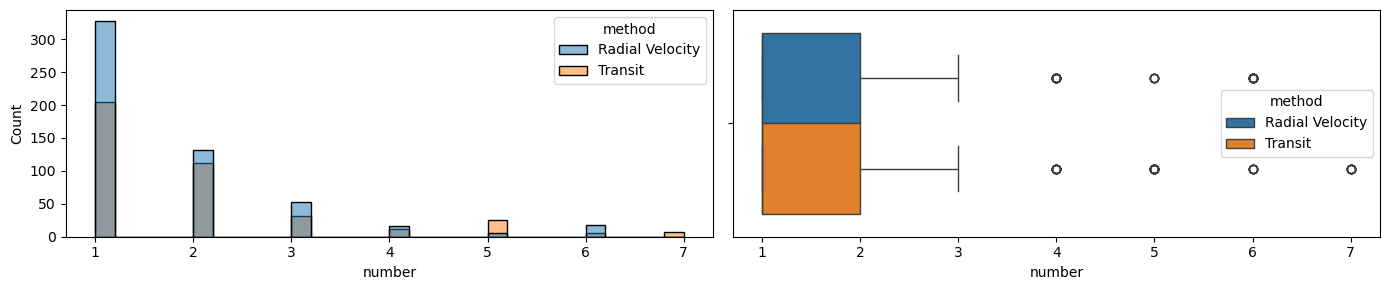

In [12]:
columns_to_drop = ["name", "year", "orbital_period", "mass", "distance"]

plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.histplot(df,x="number",hue="method")
plt.subplot(1,2,2)
sns.boxplot(df,x="number",hue="method")
plt.tight_layout()
plt.show()

From the plots related to the `orbital_period` variable, we see that the distribution is highly skewed to the right and has a long tail.
The boxplot highlights the presence of numerous outliers, especially for the "Radial Velocity" method, while for the "Transit" method the values are concentrated exclusively at 0. This suggests that for the "Transit" method, the `orbital_period` variable takes the value 0 because it is not possible to calculate the orbital period for the discovered planets; therefore, it should be considered as a missing value. But for simplicity, I will leave the value 0 as representative of this situation, as it does not significantly affect the analysis.

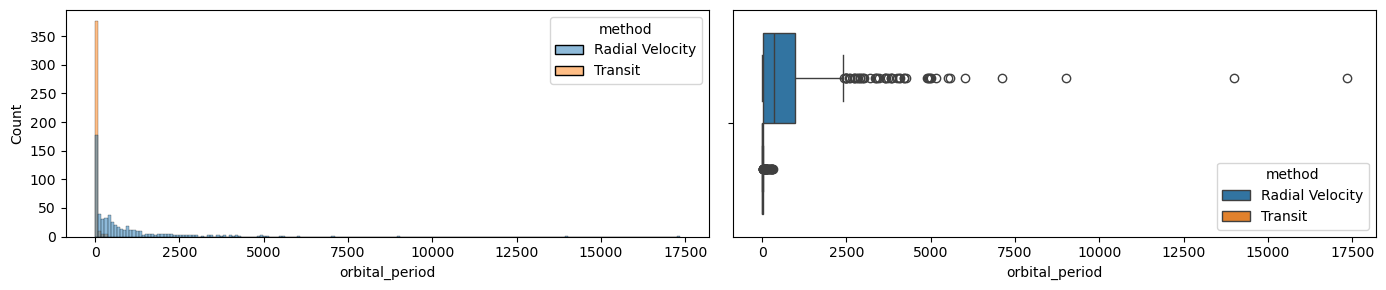

In [13]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.histplot(df,x="orbital_period",hue="method")
plt.subplot(1,2,2)
sns.boxplot(df,x="orbital_period",hue="method")
plt.tight_layout()
plt.show()

As for the `year` variable, the distribution is not symmetric: most discoveries are concentrated in recent years, with a peak between 2010 and 2014.  
The boxplot shows that the "Transit" method was used almost exclusively in recent years, while the "Radial Velocity" method covers a wider time range.  
This difference suggests that the `year` variable may have some discriminative power between the two methods.

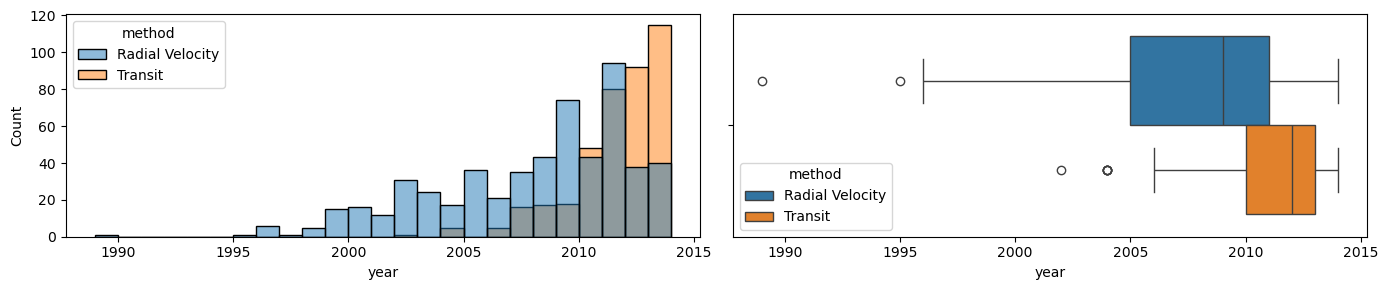

In [14]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
sns.histplot(df,x="year",hue="method")
plt.subplot(1,2,2)
sns.boxplot(df,x="year",hue="method")
plt.tight_layout()
plt.show()

## Training

After performing the univariate analysis and observing that many variables have skewed distributions and the presence of outliers, it is more appropriate to train machine learning models that do not require data normalization, such as decision trees.  
These models are less sensitive to the scale and distribution of features compared to other algorithms, such as linear models or neural networks.

In [15]:
X = df.drop(columns="method")
y = df["method"]

# Robust evaluation with stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=42)

accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall_macro')
print(f"Mean accuracy (5-fold cross-validation): {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
print(f"Mean recall (5-fold cross-validation): {recall_scores.mean():.3f} ± {recall_scores.std():.3f}")

# Final training and detailed report
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Mean accuracy (5-fold cross-validation): 0.962 ± 0.010
Mean recall (5-fold cross-validation): 0.960 ± 0.011
                 precision    recall  f1-score   support

Radial Velocity       0.99      0.98      0.99       142
        Transit       0.97      0.99      0.98        96

       accuracy                           0.98       238
      macro avg       0.98      0.98      0.98       238
   weighted avg       0.98      0.98      0.98       238



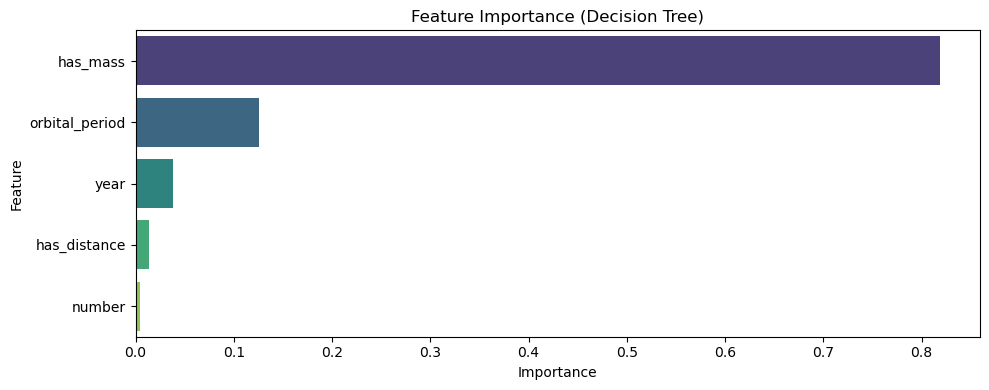

In [16]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(x=importances.values, y=importances.index, hue=importances.index, palette="viridis")
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Comment on the results

The Decision Tree model shows excellent performance both in cross-validation and on the test set:

- **Mean accuracy (5-fold cross-validation):** 0.962 ± 0.010  
- **Mean recall (5-fold cross-validation):** 0.960 ± 0.011  
- **Test set accuracy:** 0.98  
- **Precision, recall, and f1-score** are very high for both classes, with values close to or above 97%.

This indicates that the model is able to effectively distinguish between the two discovery methods ("Radial Velocity" and "Transit"), with very few classification errors.

The feature importance analysis shows that the most relevant variable is `has_mass`, i.e., the information on whether the mass value is present or not. This is followed by `orbital_period` and `year`, while the other features have negligible impact.  
This result confirms that the presence of missing values in mass is strongly associated with the discovery method, and the model mainly exploits this information for classification.

In summary, the model is very effective, but the fact that almost all predictive power is attributable to the single variable `has_mass` highlights how crucial the handling of missing values was for the final result. The strategy adopted for dealing with missing values thus proved to be crucial for the model's success.